# Basic Strategy for Dealing with Small Datasets¶

* Create a naive convnet model without regularization to set a baseline for what can be achieved.
* Data Augmentation: to prevent overfitting.
* Feature extraction with a pretrained network.
* Fine tuning a pretrained network.

In this notebook, we augment our training samples to prevent overfitting. This is done by transforming the training images to yield a larger training set. In Keras, this is done using the `ImageDataGenerator`class

```python
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)
```

In [1]:
import os

base_dir = './'

train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')                           

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')                 
                                             
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs') 

In [2]:
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

<Figure size 432x360 with 0 Axes>

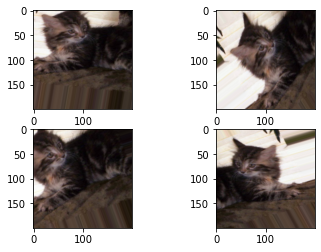

<Figure size 432x360 with 0 Axes>

<Figure size 432x360 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from keras.preprocessing import image


fnames = [os.path.join(train_cats_dir, cat_img) for cat_img in os.listdir(train_cats_dir)]

# Take some image
img_path = fnames[6]

# Load that image and resize
img = image.load_img(img_path, target_size=(200, 200))

# Convert to numpy array of shape (200, 200, 3) and then reshape to (1, 150, 150, 3)
x = image.img_to_array(img)                                    
x = x.reshape((1,) + x.shape)                                   

i = 0       
d = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}
f, ax_arr = plt.subplots(2, 2)

for batch in datagen.flow(x, batch_size=1):  
    rcParams["figure.figsize"] = [6, 5]
    plt.figure(i, figsize=(6, 5))                                               
    ax_arr[d[i]].imshow(image.array_to_img(batch[0]))      
    i += 1
    if i == 4:
        break
        
plt.show()

## New Model

The new model uses an augmented data set for training. Since the augmented set of images are created from the original pool of images, the images in the training set are highly correlated. In order to prevent overfitting, there is an additional dropout layer that is used just before the dense layer.  

In [4]:
from keras import layers
from keras import models
from keras import optimizers


model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## Model Training

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 113s 1s/step - loss: 0.6941 - acc: 0.4997 - val_loss: 0.6851 - val_acc: 0.5780
Epoch 2/100
100/100 [==============================] - 123s 1s/step - loss: 0.6849 - acc: 0.5451 - val_loss: 0.6851 - val_acc: 0.5130
Epoch 3/100
100/100 [==============================] - 123s 1s/step - loss: 0.6719 - acc: 0.5870 - val_loss: 0.6598 - val_acc: 0.6000
Epoch 4/100
100/100 [==============================] - 135s 1s/step - loss: 0.6611 - acc: 0.5925 - val_loss: 0.6358 - val_acc: 0.6280
Epoch 5/100
100/100 [==============================] - 134s 1s/step - loss: 0.6472 - acc: 0.6196 - val_loss: 0.6255 - val_acc: 0.6290
Epoch 6/100
100/100 [==============================] - 132s 1s/step - loss: 0.6330 - acc: 0.6338 - val_loss: 0.5970 - val_acc: 0.6750
Epoch 7/100
100/100 [==============================] - 132s 1s/step - loss: 0.6287 - acc: 0.6417 - val_loss: 0.6174 - val_acc: 0.6340
Epoch 8/100
100/100 [==============================] - 129s 1s